# Transfer learning to identify leukemia cells using EfficientNet B7

## Henrik Karlsson

# Environment setup

Begin with importing some required libraries

In [ ]:
try:
  import opendatasets as od
except ModuleNotFoundError:
  !pip install opendatasets
  import opendatasets as od

import os
import pandas as pd
from random import randint

import numpy as np
import cv2

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import tensorflow as tf

Download the data

In [ ]:
if not os.path.exists("/content/leukemia-classification"):
  od.download("https://www.kaggle.com/datasets/andrewmvd/leukemia-classification/download?datasetVersionNumber=2")

# Data preparation

The dataset is already split into training, testing and validation data. Unfortunately they do not all follow the same naming and structure. 

*   The training data is separated into 3 folders, each containing 2 additional folders each with ALL and Healthy cells respectively. We will use this structure to also label the images for training.
*   The validation images are all located in a folder with a separate csv-file containing the information whether they are healthy or not. Unfortunately it is not stated anywhere which label corresponds to which type, and thus I have made the guess that 0 means a healthy cell, and a 1 means an ALL cell.
*   The testing images lastly does not seem to be labelled at all. At the moment of writing I am not sure if I can use these, but this might change later on.

In [ ]:
training_path_all_0 = "/content/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all"
training_path_all_1 = "/content/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/all"
training_path_all_2 = "/content/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/all"

training_path_healthy_0 = "/content/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/hem"
training_path_healthy_1 = "/content/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/hem"
training_path_healthy_2 = "/content/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/hem"

val_images_path = "/content/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data"
val_labels_csv_path = "/content/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv"
val_labels_csv = pd.read_csv(val_labels_csv_path)


## Training images

Now we can take a look at a cancer cell as well as a healthy cell.




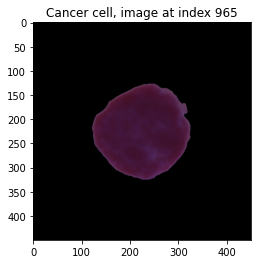

In [ ]:
idx = randint(0,len(os.listdir(training_path_all_0)))
cancer_img = cv2.imread(os.path.join(training_path_all_0, os.listdir(training_path_all_0)[idx]))
plt.imshow(cancer_img)
plt.title(f"Cancer cell, image at index {idx}")
plt.show()

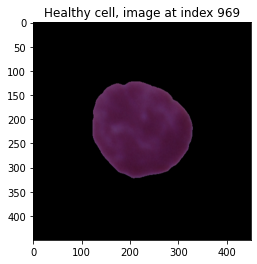

In [ ]:
idx = randint(0,len(os.listdir(training_path_healthy_0)))
healthy_img = cv2.imread(os.path.join(training_path_healthy_0, os.listdir(training_path_healthy_0)[idx]))
plt.imshow(healthy_img)
plt.title(f"Healthy cell, image at index {idx}")
plt.show()

In [ ]:
print("Cancer image size: ", cancer_img.shape)
print("Healthy image size: ", healthy_img.shape)

Cancer image size:  (450, 450, 3)
Healthy image size:  (450, 450, 3)


Now that we can see that the images do infact load and that they appear initially to be usable, we will now make a list which will contain all image paths.

In [ ]:
# Funciton to join entire path to all files in dir
def image_path(folder_path:os.path) -> list:
  image_paths = []
  folder_content = os.listdir(folder_path)
  for idx in range(len(folder_content)):
    image_path = os.path.join(folder_path, folder_content[idx])
    image_paths.append(image_path)

  return image_paths

In [ ]:
all_images = []
for path in [training_path_all_0, training_path_all_1, training_path_all_2]:
  all_images.extend(image_path(path))

print("Number of cancer images: ", len(all_images))

healthy_images = []
for path in [training_path_healthy_0, training_path_healthy_1, training_path_healthy_2]:
  healthy_images.extend(image_path(path))

print("Number of healthy images: ", len(healthy_images))

Number of cancer images:  7272
Number of healthy images:  3389


Now that we have the paths to the training images, we will combine them to a single list, and also make a separate list which will contain the labels for the training images based on their index. This will be quite easy as the first 7272 images will havce a label 1 as they are cancer cells, and the last 3389 images will have a label 0 as they are healthy cells.

In [ ]:
training_images = all_images + healthy_images
training_labels = []
for i in range(len(all_images)):
  training_labels.append(int(1))

for i in range(len(healthy_images)):
  training_labels.append(int(0))

# training_labels = pd.DataFrame(training_labels, columns=["Labels"])
# print(training_labels.dtypes)
training_labels = np.array(training_labels, dtype=np.int64)

Now we have one vector containtng the paths to all images, and one vector which contains a label for each image. As the images are added in order to both vectors, we know that the same index in both vectors will match.

## Validation images

Nex up, I will also prepare the validation images and a corresponding label vector for these.

In [ ]:
val_labels_csv.head()

Patient_ID new_names  labels
0   UID_57_29_1_all.bmp     1.bmp       1
1   UID_57_22_2_all.bmp     2.bmp       1
2   UID_57_31_3_all.bmp     3.bmp       1
3  UID_H49_35_1_hem.bmp     4.bmp       0
4   UID_58_6_13_all.bmp     5.bmp       1

Looking at the file containgin the labels for the validation pictures, I can see that the ```new_names``` corresponds to a file name in the folder, thus I can create a vector, much like the training data, and also save the label for the corresponding image in a separate vector.

In [ ]:
print("Length of validation csv: ", len(val_labels_csv))
print("Count of files in val dir: ", len(os.listdir(val_images_path)))

Length of validation csv:  1867
Count of files in val dir:  1867


As verification, we can see that there are the same ammount of files in the directory as there are listed in the CSV, thus I can safely continue with creating these vectors.

In [ ]:
from pandas.io.formats.style_render import DataFrame
val_images = []
val_labels = []

for (index, row) in val_labels_csv.iterrows():
  val_images.append(os.path.join(val_images_path, val_labels_csv.new_names[index]))
  val_labels.append(int(val_labels_csv.labels[index]))

print("Image location example: ", val_images[321])
print("Image label example: ", val_labels[321])
print("val_image list length: ", len(val_images))
print("val_labels list length: ", len(val_labels))
print("\n")

print(val_labels_csv.loc[321,], "\n")

# val_labels = pd.DataFrame(val_labels, columns=["Labels"])
# print(val_labels.info())

val_labels = np.array(val_labels, dtype=np.int64)

Image location example:  /content/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/322.bmp
Image label example:  1
val_image list length:  1867
val_labels list length:  1867


Patient_ID    UID_57_13_7_all.bmp
new_names                 322.bmp
labels                          1
Name: 321, dtype: object 



As we can now see we have a vector with the image paths and one with the labels corresponding to the images.

We can also see that the image and the label are indeed the same as denoted in the csv file, where as an example image 322 have the label 1.

## Test images


We will also prepare the test images for loading, but as they do not have any labels, all we can do is let the model predict their class and look at how confident it is, and from that try to establish if the model has any type of usable performace. 

In [ ]:
test_images_path = "/content/leukemia-classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data"
print("Count of files in test dir: ", len(os.listdir(test_images_path)))

test_images = []
for idx in range(len(os.listdir(test_images_path))):
  test_images.append(os.path.join(test_images_path, str(idx+1) + ".bmp"))

print(test_images)

Count of files in test dir:  2586
['/content/leukemia-classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/1.bmp', '/content/leukemia-classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/2.bmp', '/content/leukemia-classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/3.bmp', '/content/leukemia-classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/4.bmp', '/content/leukemia-classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/5.bmp', '/content/leukemia-classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/6.bmp', '/content/leukemia-classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/7.bmp', '/content/leukemia-classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/8.bmp', '/content/leukemia-classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/9.bmp', '/content/leukemia-classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phas

# Model preparation


Now it is tmie to prepare the model. For this I will be using the EfficientNet V2B3 model, and applying my own classifier ontop of this. 

One benefit of the EfficientNet model is that it includes a pre-processing layer, meaning that I should pass the model an image with the pixel values 0-255, as well as three color channels. This simplifies the image processing steps that we needed to take earlier.

In [ ]:
import tensorflow.keras as keras

from keras.applications import EfficientNetV2B3

In [ ]:
EffNet = EfficientNetV2B3(include_top=False, weights="imagenet", input_tensor=keras.layers.Input(shape=cancer_img.shape))
EffNet.summary()

Model: "efficientnetv2-b3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 450, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 450, 450, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 450, 450, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 225, 225, 40  1080        ['normalization[0

As we can see here, EfficientNet V2B3 is quite large, with quite a lot of layers. In the end the network presents with about 14.3M trainable parameters and 100K non-trainable parameters. Though this is not of too much interest at this moment as I willuse the pre-trained weigths and only add my own classifier to train in the end.

To do this I first have to freeze all the layers in the EfficientNet model t make sure that they are not trained.

In [ ]:
EffNet.trainable = False

for layer in EffNet.layers:
  spacing = '                  '[len(layer.name)-9:]
  print(layer.name, spacing, layer.trainable)

input_1    False
rescaling                    False
normalization                False
stem_conv                    False
stem_bn    False
stem_activation              False
block1a_project_conv         False
block1a_project_bn           False
block1a_project_activation   False
block1b_project_conv         False
block1b_project_bn           False
block1b_project_activation   False
block1b_drop                 False
block1b_add                  False
block2a_expand_conv          False
block2a_expand_bn            False
block2a_expand_activation    False
block2a_project_conv         False
block2a_project_bn           False
block2b_expand_conv          False
block2b_expand_bn            False
block2b_expand_activation    False
block2b_project_conv         False
block2b_project_bn           False
block2b_drop                 False
block2b_add                  False
block2c_expand_conv          False
block2c_expand_bn            False
block2c_expand_activation    False
block2c_project_conv 

As we can now see, all the layers are no longre trainable. 

As we want to use our own classifier, I have used `include_top=False` when loading the model, as this makes it so that the final, fully connected layer is not present, and thus I will be able to use my own classifier.

## Bulding the model

Now that we have all these preparations ready, it is time to build the model. I will build thsi model in a way to allow me to perform keras hyperparameter tuning at initial training, thus hopefully allowing me to optimize the classifier layers as much as possible. I will be using the Bayesian Optimization as that is the one used earlier in the course.

My classifier will be constructed as having two Conv2D layers, connecting to a Dense layer, which will end at a Dense layer with only 2 nodes.

In [ ]:
try:
  import keras_tuner
except ModuleNotFoundError:
  !pip install keras_tuner
  import keras_tuner

from keras_tuner.tuners import BayesianOptimization
from keras.models import Model, Sequential
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization, Flatten

Note, after running the hp-optimizer once, I have updated the values that is used for optimization, and will run it again to hopefully improve the results further.

After a second run, slight improvements were found. As the best result right now is at the maximums of the given intervals, I will do a third run. This will however be the last as the time I have comes to an end.

In [ ]:
def build_model(hp):
  # The first part of the model are all but the 6 last layers of EfficientNet
  inputs = keras.Input(shape=cancer_img.shape)

  model = EffNet(inputs, training=False)
  
  # First Convolutional Layer
  model = keras.layers.Conv2D(
          filters=hp.Int('conv_1_filter', min_value=8, max_value=256, step=8),
          kernel_size=hp.Choice('conv_1_kernel', values = [3,5,7]),
          activation='relu',
          padding='same')(model)

  model = keras.layers.BatchNormalization()(model)

  # Second Convolutional Layer
  model = keras.layers.Conv2D(
          filters=hp.Int('conv_2_filter', min_value=8, max_value=256, step=8),
          kernel_size=hp.Choice('conv_2_kernel', values = [3,5,7]),
          activation='relu',
          padding='same')(model)

  model = keras.layers.BatchNormalization()(model)


  # A First Dense Layer
  model = keras.layers.Flatten()(model)

  model = keras.layers.Dropout(
          rate=hp.Float('dropout_1_rate', min_value=0.0, max_value=0.7, step=0.1)
          )(model)
  
  model = keras.layers.Dense(
          units=hp.Int('dense_1_units', min_value=8, max_value=128, step=8),
          activation='relu')(model)

  # A Final Dense Layer
  model = keras.layers.Flatten()(model)

  outputs = keras.layers.Dense(2, activation='softmax')(model)


  model = keras.Model(inputs, outputs, name="ALL_Classification_Model")

  model.summary()
  
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

I will here be using some code from the first lab, as that code was easily understood and worked well.

In [ ]:
# To get more stable results we are repeating the runs two times for each parameter setup
MAX_TRIALS = 20         # represents the number of hyperparameter combinations that will be tested by the tuner
EXECUTION_PER_TRIAL = 2 # the number of models that should be built and fit for each trial for robustness purposes

In [ ]:
# To have batch_size as a hyperparameter we need to define our own tuner
# In this case, we are basing it on the BayesianOptimization tuner found in
# https://keras-team.github.io/keras-tuner/documentation/tuners/#bayesianoptimization-class
class MyTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 1024, step=32, default=256)
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [ ]:
# Bayesian search which also searches for batch_size
tuner = MyTuner(
    build_model,
    max_trials=MAX_TRIALS,
    objective='val_accuracy',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output',
    overwrite=True,
    num_initial_points=10, # Start with 10 random points and then do more structured search
    project_name='ALL Classification'
)

Model: "ALL_Classification_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 450, 450, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, 15, 15, 1536)     12930622  
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, 15, 15, 8)         110600    
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 8)        32        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 8)         584       
                                                                 
 batch_normalization_1 (Batc  (None, 15, 1

# Loading images or streaming images

Now that the model is ready, we need to load the images from earlier. To do this, I will use the keras `load_img` function to load the images into a format that can be used by the model. As I will load the images in the same order as they are earlier, the label vector will still be accurate.

Unfortunately, the images cannot be loaded all at once, and we must thus create a sequence generator that allow us to stream images to the training process, lessening the load on the system memory. I will be using the example provided on Canvas and adapt that to suit this data.

In [ ]:
from keras.utils import load_img, img_to_array, Sequence

In [ ]:
def img_transform(images):
  loaded_images = []
  for img_path in images:
    image = keras.utils.load_img(img_path, color_mode="rgb", interpolation="nearest", target_size=None)
    input_arr = keras.utils.img_to_array(image)
    loaded_images.append(input_arr)

  return loaded_images

# Define a Sequence generator
class train_val_generator(Sequence):
  def __init__(self, x_set, y_set, batch_size):
    self.x, self.y = x_set, y_set
    self.batch_size = batch_size

  def __len__(self):
    return int(np.ceil(len(self.x) / float(self.batch_size)))

  def __getitem__(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

    # transform the images to fit the model constraints
    x=img_transform(batch_x)
    batch_y_int = [int(val) for val in batch_y]
    return np.array(x), np.array(batch_y_int)
        

# Generate data streams from data sets
batch_size = 128
train_gen = train_val_generator(training_images, training_labels, batch_size = batch_size )
val_gen = train_val_generator(val_images, val_labels, batch_size = batch_size )

## Running keras tuner

Worth noting is that the optimization runs takes longer than the time I have with Colab, and the runs are forced to quit early. As the search is more and more optimized throughout the run, there might be slight improvements that I am missing out on. But as I do not have an Nvidia GPU in my own machine I cannot launch a local run instance that can run to completion. I do have an AMD GPU, but as it is a Vega 64, which as far as I understand was a bit of an unusual architechture and there are not a lot of these cards in use, I have not found a good solution that would not require me to format my computer to run some Linux distibution where some tool "might" work. It was also not possible to run this tool through windows WSL as it does not support GPU passthrough at this time either. 

In [ ]:
# Do the hyperparameter search
# I set the no of epochs to 6 to speed up the search in this excersise, better would have been 10
noepochauto = 6   ## Max number of epochs per trail (but we have early stopping so this max is probably not reached)
es = tf.keras.callbacks.EarlyStopping('val_loss', patience=2, restore_best_weights = True)

# Note we do not need to_catagorical as we use loss='sparse_categorical_crossentropy'
# This function is comented out to allow me to easily do Run All, and not have to sit though optimization each time
# tuner.search(train_gen, 
#              epochs=noepochauto, 
#              validation_data=val_gen, 
#              callbacks=[es])

The first round of hyperparameter optimization reached a val_accuracy of about 66.5%. A second run with more specific values yielded a best-case val_accuracy of 68.5%. 

These were the fouind parameters of the second run. Unfortunately I forgot to save them from the first run.
```
Best Value So Far |Hyperparameter
64                |conv_1_filter
7                 |conv_1_kernel
64                |conv_2_filter
3                 |conv_2_kernel
0.1               |dropout_1_rate
88                |dense_1_units
0.0001            |learning_rate
32                |batch_size
```
After a third pass, no improvements were seen, and I will contrinue with the paramaters listed above as they are the best that I found for now.

# Optimized model building and more training

Now that the optimizer has found some good (but maybe not the absolute best) parameters for this problem, we will build a model again which will be allowed to train for as long as it wants. I will utilize early stopping to reduce overfitting, but as the optimizer ony run for a maximum of 6 epochs, there might be slight improvements that can be found from being allowed to train further if needed. 

In [ ]:
def final_model():
  '''
  Function to generate a model. Does not take an input, but requires the EffNet model to be loaded and set to not be trainable earlier.

  Returns: Compiled model
  '''
  # The first part of the model are all but the 6 last layers of EfficientNet
  inputs = keras.Input(shape=cancer_img.shape)

  model = EffNet(inputs, training=False)
  
  # First Convolutional Layer
  model = keras.layers.Conv2D(
          filters=64,
          kernel_size=7,
          activation='relu',
          padding='same')(model)

  model = keras.layers.BatchNormalization()(model)

  # Second Convolutional Layer
  model = keras.layers.Conv2D(
          filters=64,
          kernel_size=3,
          activation='relu',
          padding='same')(model)

  model = keras.layers.BatchNormalization()(model)


  # A First Dense Layer
  model = keras.layers.Flatten()(model)

  model = keras.layers.Dropout(rate=0.1)(model)
  
  model = keras.layers.Dense(
          units=88, activation='relu')(model)

  # A Final Dense Layer
  model = keras.layers.Flatten()(model)

  outputs = keras.layers.Dense(2, activation='softmax')(model)


  model = keras.Model(inputs, outputs, name="Final_ALL_Classification_Model")

  model.summary()
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [ ]:
epochs = 100
batch_size = 32

model = final_model()
train_gen = train_val_generator(training_images, training_labels, batch_size = batch_size )
val_gen = train_val_generator(val_images, val_labels, batch_size = batch_size )
es = tf.keras.callbacks.EarlyStopping('val_loss', patience=2, restore_best_weights = True)

history = model.fit(train_gen, 
             epochs=epochs, 
             validation_data=val_gen, 
             callbacks=[es])

Model: "Final_ALL_Classification_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 450, 450, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, 15, 15, 1536)     12930622  
 al)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        4816960   
                                                                 
 batch_normalization_2 (Batc  (None, 15, 15, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 64)        36928     
                                                                 
 batch_normalization_3 (Batc  (None,

Using the code from earlier labs to get some graphs.

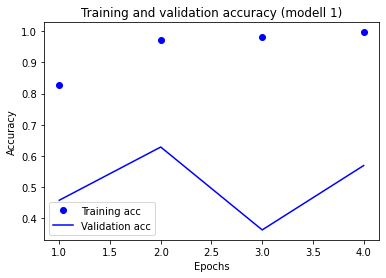

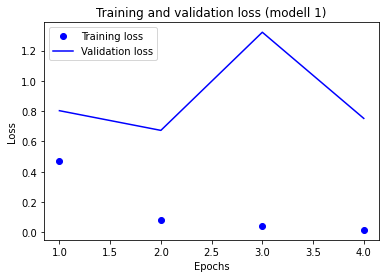

In [ ]:
epochrange = range(1, 5)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochrange, train_acc, 'bo', label='Training acc')
plt.plot(epochrange, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochrange, train_loss, 'bo', label='Training loss')
plt.plot(epochrange, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (modell 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Final notes

As can be seen in above sections, this did not work very well. If it is due to the small size of the dataset, my own lack of knowledge, or that the data itself was not suited for this type of analysis I don't know. 

This is unfortunate, but sometimes the answer to a quiestion is no. And in the case of if transfer learning can be used to identify ALL cells, the answer was no. At least for now. Seeing as this field is moving forward at an incredible pace, this might very well be possible in the not so distant future. But for now, an accuracy of ~65% is not nearly good enough, as simply flipping a coin is almost as accurate.

## Testing the model

As noted above, the validation performance is not very good, and thus I have not proceeded with testing the model with test images, however bellow I have provided som example code which should be able to be adapted to work with this model.

In [ ]:
def img_transform(images):
  loaded_images = []
  for img_path in images:
    image = keras.utils.load_img(img_path, color_mode="rgb", interpolation="nearest", target_size=None)
    input_arr = keras.utils.img_to_array(image)
    loaded_images.append(input_arr)

  return loaded_images

# Define a Sequence generator
class test_generator(Sequence):
  """
  Generates a sequence of images with no associated validation labels attached.
  """
  def __init__(self, x_set, batch_size):
    self.x = x_set
    self.batch_size = batch_size

  def __len__(self):
    return int(np.ceil(len(self.x) / float(self.batch_size)))

  def __getitem__(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]

    # transform the images to fit the model constraints
    x=img_transform(batch_x)
    return np.array(x)

In [ ]:
batch_size = 32
test_sequence = test_generator(test_images, batch_size)
rand_idx = randint(0, len(test_images))

test_image = keras.utils.load_img(test_images[rand_idx], color_mode="rgb", interpolation="nearest", target_size=(450,450))
test_image_array = keras.utils.img_to_array(test_image)
test_image_array = tf.expand_dims(test_image_array, 0)


predictions = model.predict(test_image_array)

score = tf.nn.softmax(predictions[0])
class_names = ["Healthy", "ALL"]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 36ms/step
This image most likely belongs to Healthy with a 66.42 percent confidence.
